In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from icecream import install
install()
import traceback
import torch
import random
import multiprocessing

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

LOCALS = ['NVD4K9M6K4', 'x1']
import socket
hostname = socket.gethostname()
IS_LOCAL = hostname in LOCALS
MAX_WORKERS = 20 if not IS_LOCAL else 8
# IS_LOCAL = False

if hostname == "NVD4K9M6K4":
    multiprocessing.set_start_method("fork")


def view_df(data: pd.DataFrame):
    pd.set_option('display.max_columns', None)
    display(data)
    pd.reset_option("max_columns")

if IS_LOCAL:
    %load_ext autoreload
    %autoreload 2

# Load data

In [2]:
import glob
import zipfile
import os
from tqdm.auto import tqdm
import concurrent.futures

def read_pv2006_state(zipname):
    # print(f'Reading {zipname}: {os.stat(zipname).st_size} bytes', flush=True)
    with zipfile.ZipFile(zipname) as zf:
        dfs = []
        s = os.path.basename(zipname).split('-')
        state = "-".join(s[:-2])
        for file in zf.namelist():
        # for file in tqdm(zf.namelist(), desc=f"{os.path.basename(zipname)}"):
            if not file.endswith('.csv'):
                continue
            data_type, latitude, longitude, weather_year, pv_type, capacity, time_interval, _ = file.split('_')
            if data_type != "Actual":
                continue
            with zf.open(file) as f:
                df = pd.read_csv(f)
                df['LocalTime'] = pd.to_datetime(df['LocalTime'])
                df['data_type'] = data_type
                df['latitude'] = latitude
                df['longitude'] = longitude
                # df['weather_year'] = weather_year
                df['pv_type'] = pv_type
                df['capacity'] = capacity[:-2] # ignore "MW" suffix
                # df['time_interval'] = time_interval
                df['state'] = state
                df['filename'] = file
                dfs.append(df)
                # view_df(df); return
    return pd.concat(dfs, axis=0)

data_dir = Path(f'data/lstm/')
data_dir.mkdir(exist_ok=True)

files = glob.glob("data/*.zip")
if IS_LOCAL:
        # files = random.sample(files, k=1)
        n_states = 1
else:
    # n_states = 5
    # n_states = len(files)
    n_states = 1

train_pkl = data_dir / f'train_{n_states}.pkl'
val_pkl = data_dir / f'val_{n_states}.pkl'
test_pkl = data_dir / f'test_{n_states}.pkl'
PKL_AVAILABLE = train_pkl.is_file() and val_pkl.is_file() and test_pkl.is_file()

if not PKL_AVAILABLE:
    dfs = []
    files = files[:n_states]
        
    with tqdm(total=len(files)) as pbar:
        max_workers = min(MAX_WORKERS, len(files), os.cpu_count())
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(read_pv2006_state, file): file for file in files}
            for future in concurrent.futures.as_completed(futures):
                # print(f"Done ({cnt}/{len(futures)}): {futures[future]}")
                # file = futures[file]
                df = future.result()
                dfs.append(df)      
                pbar.update(1)
    df = pd.concat(dfs, axis=0)
    view_df(df)

# Preprocessing

In [3]:
CYCLIC_COLS = [
    'hour',
    'minute',
    'day',
    'day_of_week'
]

new_cyclic_cols = [
    c for col in CYCLIC_COLS for c in [f'{col}_sin', f'{col}_cos']
]

def add_cyclic_cols(df):
    for col in CYCLIC_COLS:
        df[f"{col}_sin"]  = np.sin((2*np.pi*df[col].astype(float))/max(df[col].astype(float)))
        df[f"{col}_cos"]  = np.cos((2*np.pi*df[col].astype(float))/max(df[col].astype(float)))
    return df

if not PKL_AVAILABLE:
    df.sort_values(by='LocalTime', inplace=True)
    tmin = df['LocalTime'].min()
    time_from_start = df['LocalTime'] - tmin
    df['time_idx'] = pd.to_numeric(time_from_start.dt.total_seconds() / 300, downcast='integer')
    df['minute'] = df['LocalTime'].dt.minute
    df['hour'] = df['LocalTime'].dt.hour
    df['day'] = df['LocalTime'].dt.day
    df['day_of_week'] = df['LocalTime'].dt.dayofweek
    df['month'] = df['LocalTime'].dt.month
    df['year'] = df['LocalTime'].dt.year
    # df['sensor'] = df.apply(lambda row: '_'.join([row["state"]] + row['filename'].split('_')[1:-2]), axis=1)
    df['sensor'] = df['state'] + '_' + df['filename'].str.split("_").str[1:-2].str.join('_')
    df = add_cyclic_cols(df)
    df['group_id'] = 'x'
    view_df(df)

In [5]:
import pickle

testing_cutoff_time = pd.to_datetime('2006/12/01')
validation_cutoff_time = pd.to_datetime('2006/11/01')

def convert(df, sensors):
    """
    Convert ....
    """
    out = df
    cat_cols = ["minute", "hour", "day", "day_of_week","month", "year", "data_type", "sensor", "state", "pv_type", 'group_id']
    for col in cat_cols:
        out[col] = out[col].astype(str).astype('category')
    cont_cols = ["latitude", "longitude", "capacity"]
    for col in cont_cols:
        out[col] = out[col].astype(float)
    return out

if not PKL_AVAILABLE:
    sensors = df['sensor'].unique().tolist()
    train_df = df[df['LocalTime'] < validation_cutoff_time]
    val_df = df[(df["LocalTime"] >= validation_cutoff_time) & (df["LocalTime"] < testing_cutoff_time)]
    test_df = df[(df["LocalTime"] >= testing_cutoff_time)]

    train_df = convert(train_df, sensors)
    val_df = convert(val_df, sensors)
    test_df = convert(test_df, sensors)

    with open(train_pkl, 'wb') as fp:
        pickle.dump(train_df, fp)
    with open(val_pkl, 'wb') as fp:
        pickle.dump(val_df, fp)
    with open(test_pkl, 'wb') as fp:
        pickle.dump(test_df, fp)
else:
    with open(train_pkl, 'rb') as fp:
        train_df = pickle.load(fp)
    with open(val_pkl, 'rb') as fp:
        val_df = pickle.load(fp)
    with open(test_pkl, 'rb') as fp:
        test_df = pickle.load(fp)
    train_df = add_cyclic_cols(train_df)
    val_df = add_cyclic_cols(val_df)
    test_df = add_cyclic_cols(test_df)
    sensors = train_df['sensor'].unique().tolist()

ic(train_df.shape, val_df.shape, test_df.shape)
ic(len(files), len(sensors))
if IS_LOCAL:
    ic(sensors)
    view_df(train_df)

ic| train_df.shape: (2013696, 26)
    val_df.shape: (198720, 26)
    test_df.shape: (205344, 26)
ic| len(files): 51, len(sensors): 23
ic| sensors: ['me_43.15_-70.75_2006_UPV_9MW',
              'me_43.85_-70.25_2006_DPV_23MW',
              'me_43.95_-69.75_2006_UPV_19MW',
              'me_43.45_-70.65_2006_UPV_38MW',
              'me_43.85_-70.35_2006_DPV_23MW',
              'me_43.25_-70.65_2006_UPV_85MW',
              'me_44.45_-69.75_2006_DPV_31MW',
              'me_43.45_-70.65_2006_DPV_26MW',
              'me_43.65_-70.55_2006_UPV_66MW',
              'me_44.25_-69.85_2006_UPV_19MW',
              'me_44.25_-70.35_2006_UPV_94MW',
              'me_43.35_-70.85_2006_UPV_56MW',
              'me_44.25_-69.65_2006_UPV_9MW',
              'me_43.75_-70.35_2006_UPV_19MW',
              'me_43.95_-70.25_2006_UPV_28MW',
              'me_43.85_-70.55_2006_UPV_85MW',
              'me_44.15_-70.05_2006_UPV_19MW',
              'me_43.55_-70.85_2006_UPV_94MW',
              'me_43.5

,LocalTime,Power(MW),data_type,latitude,longitude,pv_type,capacity,state,filename,time_idx,minute,hour,day,day_of_week,month,year,sensor,group_id,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
0,2006-01-01 00:00:00,0.0,Actual,43.15,-70.75,UPV,9.0,me,Actual_43.15_-70.75_2006_UPV_9MW_5_Min.csv,0,0,0,1,6,1,2006,me_43.15_-70.75_2006_UPV_9MW,x,0.000000e+00,1.0,0.000000e+00,1.0,2.012985e-01,0.97953,-2.449294e-16,1.0
0,2006-01-01 00:00:00,0.0,Actual,43.85,-70.25,DPV,23.0,me,Actual_43.85_-70.25_2006_DPV_23MW_5_Min.csv,0,0,0,1,6,1,2006,me_43.85_-70.25_2006_DPV_23MW,x,0.000000e+00,1.0,0.000000e+00,1.0,2.012985e-01,0.97953,-2.449294e-16,1.0
0,2006-01-01 00:00:00,0.0,Actual,43.95,-69.75,UPV,19.0,me,Actual_43.95_-69.75_2006_UPV_19MW_5_Min.csv,0,0,0,1,6,1,2006,me_43.95_-69.75_2006_UPV_19MW,x,0.000000e+00,1.0,0.000000e+00,1.0,2.012985e-01,0.97953,-2.449294e-16,1.0
0,2006-01-01 00:00:00,0.0,Actual,43.45,-70.65,UPV,38.0,me,Actual_43.45_-70.65_2006_UPV_38MW_5_Min.csv,0,0,0,1,6,1,2006,me_43.45_-70.65_2006_UPV_38MW,x,0.000000e+00,1.0,0.000000e+00,1.0,2.012985e-01,0.97953,-2.449294e-16,1.0
0,2006-01-01 00:00:00,0.0,Actual,43.85,-70.35,DPV,23.0,me,Actual_43.85_-70.35_2006_DPV_23MW_5_Min.csv,0,0,0,1,6,1,2006,me_43.85_-70.35_2006_DPV_23MW,x,0.000000e+00,1.0,0.000000e+00,1.0,2.012985e-01,0.97953,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87551,2006-10-31 23:55:00,0.0,Actual,44.15,-70.05,UPV,19.0,me,Actual_44.15_-70.05_2006_UPV_19MW_5_Min.csv,87551,55,23,31,1,10,2006,me_44.15_-70.05_2006_UPV_19MW,x,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.00000,8.660254e-01,0.5
87551,2006-10-31 23:55:00,0.0,Actual,44.25,-70.35,UPV,94.0,me,Actual_44.25_-70.35_2006_UPV_94MW_5_Min.csv,87551,55,23,31,1,10,2006,me_44.25_-70.35_2006_UPV_94MW,x,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.00000,8.660254e-01,0.5
87551,2006-10-31 23:55:00,0.0,Actual,43.75,-70.35,UPV,19.0,me,Actual_43.75_-70.35_2006_UPV_19MW_5_Min.csv,87551,55,23,31,1,10,2006,me_43.75_-70.35_2006_UPV_19MW,x,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.00000,8.660254e-01,0.5
87551,2006-10-31 23:55:00,0.0,Actual,43.55,-70.65,DPV,26.0,me,Actual_43.55_-70.65_2006_DPV_26MW_5_Min.csv,87551,55,23,31,1,10,2006,me_43.55_-70.65_2006_DPV_26MW,x,-2.449294e-16,1.0,-2.449294e-16,1.0,-2.449294e-16,1.00000,8.660254e-01,0.5


In [9]:
from united.data.timeseries import TimeSeriesDataset

max_encoder_length =  7*24
max_prediction_length = 24

targets = ["Power(MW)"]
cat_cols = [
    "minute",
    "hour",
    "day",
    "day_of_week",
    # "month",
    # "year",
    # "data_type",
    "sensor",
    # "state",
    # "pv_type",
]
cont_cols = ["latitude", "longitude", "capacity"]
encoder_variables = cat_cols + cont_cols + targets
decoder_variables = cat_cols + cont_cols
train_dataset = TimeSeriesDataset(
    data=train_df,
    group_ids="sensor",
    time_idx="time_idx",
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_decoder_length=max_prediction_length,
    max_decoder_length=max_prediction_length,
    encoder_variables=encoder_variables,
    decoder_variables=decoder_variables,
    targets=targets,
    training=True,
    # imputers={
    #     sensor: 'tryhard' for sensor in sensors
    # },
    return_missing_mask=False,
)

val_dataset = TimeSeriesDataset.from_dataset(
    train_dataset, val_df, training=False
)
test_dataset = TimeSeriesDataset.from_dataset(
    train_dataset, test_df, training=False
)
if IS_LOCAL:
    batch_size = 64
    num_workers = 0
else:
    batch_size = 256
    num_workers = 8

train_loader = train_dataset.to_dataloader(
    batch_size=batch_size, num_workers=num_workers
)
val_loader = val_dataset.to_dataloader(batch_size=batch_size)
test_loader = test_dataset.to_dataloader(batch_size=batch_size)



it_ = iter(train_loader)

ic(len(train_dataset), len(val_dataset), len(test_dataset))
ic(len(train_loader), len(val_loader), len(test_loader))

Indexing - step 2/2:   0%|          | 0/23 [00:00<?, ?it/s]

Indexing - step 1/2:   0%|          | 0/23 [00:00<?, ?it/s]

Finished Indexing in 394.04(s)
Preprocessing ...
Done


Indexing - step 2/2:   0%|          | 0/23 [00:00<?, ?it/s]

Indexing - step 1/2:   0%|          | 0/23 [00:00<?, ?it/s]

Finished Indexing in 45.60(s)
Preprocessing ...
Done


Indexing - step 2/2:   0%|          | 0/23 [00:00<?, ?it/s]

Indexing - step 1/2:   0%|          | 0/23 [00:00<?, ?it/s]

Finished Indexing in 44.03(s)
Preprocessing ...


ic| len(train_dataset): 2009280
    len(val_dataset): 194304
    len(test_dataset): 200928
ic| len(train_loader): 31395
    len(val_loader): 3036
    len(test_loader): 3140


Done


(31395, 3036, 3140)

In [6]:
# cont_cols = ["latitude", "longitude", "capacity"]
# for col in cont_cols:
#     train_df[col] = train_df[col].astype(float)
#     val_df[col] = val_df[col].astype(float)
#     test_df[col] = test_df[col].astype(float)


# train_pkl = data_dir / 'train.pkl'
# val_pkl = data_dir / 'val.pkl'
# test_pkl = data_dir / 'test.pkl'
# with open(train_pkl, 'wb') as fp:
#     pickle.dump(train_df, fp)
# with open(val_pkl, 'wb') as fp:
#     pickle.dump(val_df, fp)
# with open(test_pkl, 'wb') as fp:
#     pickle.dump(test_df, fp)

In [7]:
# df['pv_type'].value_counts(), len(df['sensor'].unique())

In [8]:
from united.models.lstm_forecasting import LSTMForecaster
model = LSTMForecaster.from_dataset(
    train_dataset,
    # hidden_size=256
)

_ = ic(model.features)

ModuleNotFoundError: No module named 'pytorch_forecasting_extras'

# Training

In [ ]:
from lightning import Trainer
import lightning.pytorch as pl 
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
pl.seed_everything(42)
max_epochs = 50
early_stoping_callback = EarlyStopping(
    monitor='val/loss', 
    min_delta=1e-5, 
    patience=max_epochs//5, 
    verbose=False, 
    mode='min'
)
model_checkpoint_callback = ModelCheckpoint(
    monitor='val/loss', 
    mode='min', 
    save_last=True, 
    # save_top_k=1
)
lr_logger = LearningRateMonitor()
if isinstance(model, LSTMForecaster):
    sub_dir = 'lstm'
# elif isinstance(model, TransformerTagging):
#     sub_dir = 'tf'
log_dir = f'runs/{sub_dir}/{"dev" if IS_LOCAL else "prod"}'
tb_logger = TensorBoardLogger(log_dir)

trainer = Trainer(
    max_epochs=max_epochs,
    # min_epochs=5,
    enable_model_summary=True,
    callbacks=[
        lr_logger, 
        early_stoping_callback, 
        model_checkpoint_callback
    ],
    logger=tb_logger,
    gradient_clip_val=5.,
    # max_steps=300,
    # fast_dev_run=True
    # log_every_n_steps=10
)

Global seed set to 42


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lstm/dev/lightning_logs

  | Name       | Type       | Params
------------------------------------------
0 | embeddings | ModuleDict | 883   
1 | rnn        | LSTM       | 28.9 K
2 | predictors | ModuleDict | 65    
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [ ]:
# if IS_LOCAL:
#     from lightning.pytorch.tuner import Tuner
#     res = Tuner(trainer).lr_find(
#         model,
#         train_dataloaders=train_loader,
#         val_dataloaders=val_loader
#     )
#     print(f"suggested learning rate: {res.suggestion()}")
#     fig = res.plot(show=True, suggest=True)
#     fig.show()

In [ ]:
trainer.fit(
    model=model, 
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)
trainer.test(
    model,
    ckpt_path='best',
    dataloaders=test_loader,
)

In [ ]:
if not IS_LOCAL:
    sys.exit()

# Inference with trained models

In [7]:
from united.models.lstm_forecasting import LSTMForecaster
from united.data.timeseries import TimeSeriesDataset
# model_path = 'runs/lstm/prod/lightning_logs/version_2/checkpoints/epoch=0-step=7848.ckpt'
model_path = 'runs/lstm/prod/lightning_logs/version_3/checkpoints/epoch=0-step=7848.ckpt'

model = LSTMForecaster.load_from_checkpoint(
    model_path, 
    map_location=torch.device('cpu'),
    # dataset_params=train_dataset.get_parameters(),
    # dataset_props=train_dataset.get_properties(),
)


model.eval()
print(model.dataset_params)

test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)

batch_size = 64
num_workers = 1
    
test_loader     = test_dataset.to_dataloader(batch_size=batch_size, shuffle=True)

it_ = iter(test_loader)

ic(len(test_dataset))
ic(len(test_loader))

{'group_ids': 'sensor', 'time_idx': 'time_idx', 'min_encoder_length': 168, 'max_encoder_length': 168, 'min_decoder_length': 24, 'max_decoder_length': 24, 'encoder_variables': ['minute', 'hour', 'day', 'day_of_week', 'sensor', 'latitude', 'longitude', 'capacity', 'Power(MW)'], 'decoder_variables': ['minute', 'hour', 'day', 'day_of_week', 'sensor', 'latitude', 'longitude', 'capacity'], 'targets': ['Power(MW)'], 'static_variables': [], 'training': True, 'random_length': True, 'scalers': {'hour': NaNLabelEncoder, 'minute': NaNLabelEncoder, 'day_of_week': NaNLabelEncoder, 'sensor': NaNLabelEncoder, 'day': NaNLabelEncoder, 'Power(MW)': StandardScaler(), 'latitude': StandardScaler(), 'capacity': StandardScaler(), 'longitude': StandardScaler()}, 'target_normalizers': {'Power(MW)': StandardScaler()}, 'imputers': None, 'add_na': False, 'ignore_na': False, 'allow_missing_time_steps': False, 'unknown_value': nan, 'non_overlapped_windows': False, 'return_missing_mask': False}


Indexing - step 2/2:   0%|          | 0/23 [00:00<?, ?it/s]

Indexing - step 1/2:   0%|          | 0/23 [00:00<?, ?it/s]

Finished Indexing in 40.79(s)
Preprocessing ...


ic| len(test_dataset): 200928
ic| len(test_loader): 3140


Done


3140

In [8]:
from lightning import Trainer

trainer = Trainer()
trainer.test(
    model,
    dataloaders=test_loader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ALL/test/mse        │     43.26713943481445     │
│       ALL/test/rmse       │     6.577775955200195     │
│       ALL/test/rse        │    0.7141484022140503     │
│      ALL/test/smape       │    1.5954458713531494     │
│   Power(MW)/test/loss/    │    0.30489230155944824    │
│    Power(MW)/test/mse     │     43.26713943481445     │
│    Power(MW)/test/rmse    │     6.577775955200195     │
│    Power(MW)/test/rse     │    0.7141484022140503     │
│   Power(MW)/test/smape    │    1.5954458713531494     │
│         test/loss         │    0.30489230155944824    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.30489230155944824,
  'Power(MW)/test/loss/': 0.30489230155944824,
  'Power(MW)/test/mse': 43.26713943481445,
  'Power(MW)/test/rmse': 6.577775955200195,
  'Power(MW)/test/smape': 1.5954458713531494,
  'Power(MW)/test/rse': 0.7141484022140503,
  'ALL/test/mse': 43.26713943481445,
  'ALL/test/rmse': 6.577775955200195,
  'ALL/test/smape': 1.5954458713531494,
  'ALL/test/rse': 0.7141484022140503}]

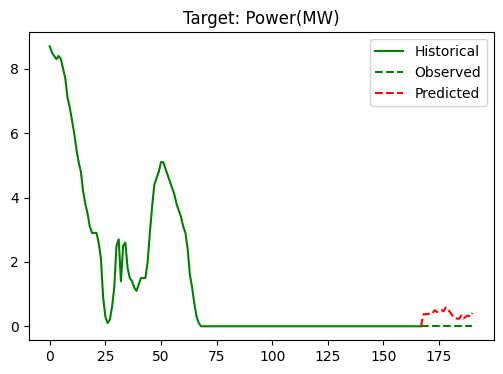

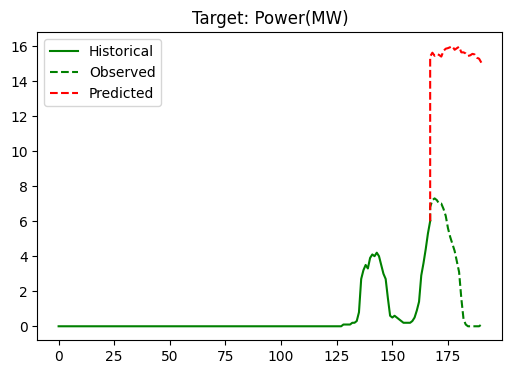

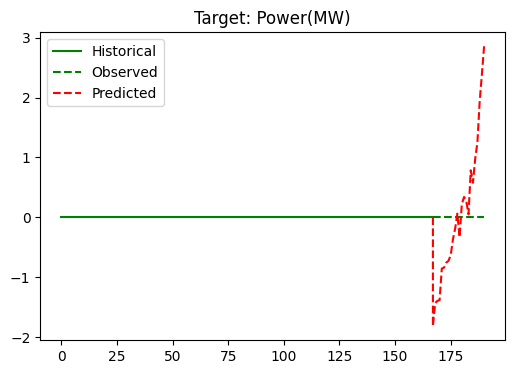

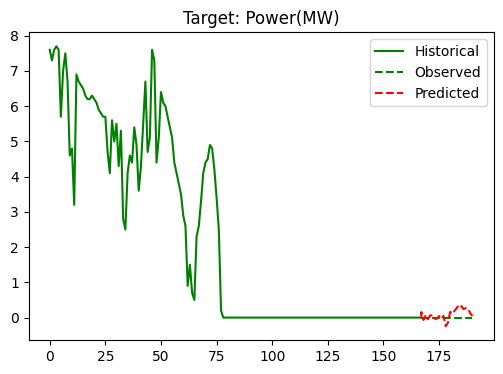

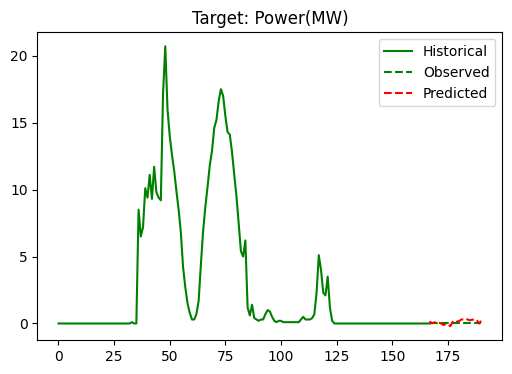

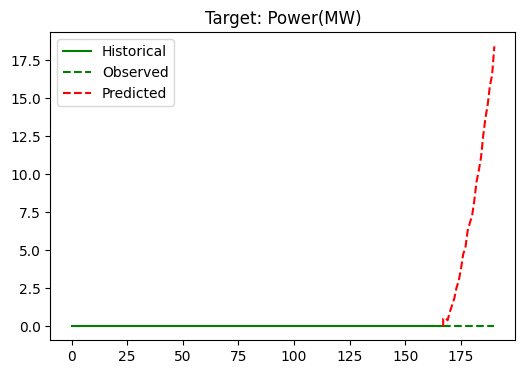

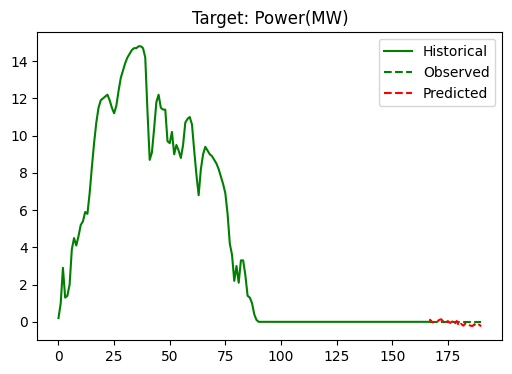

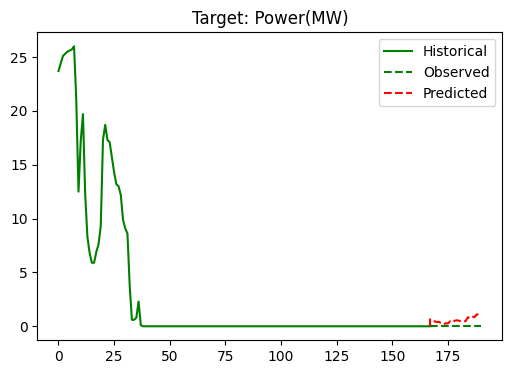

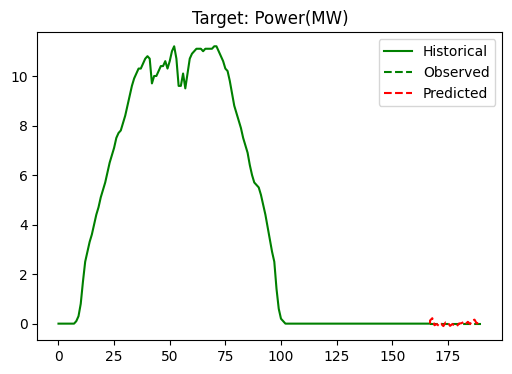

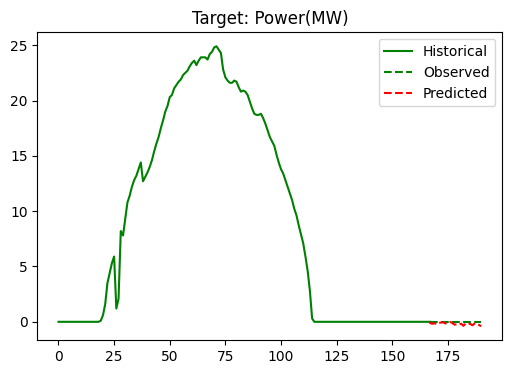

In [13]:
model.eval()
for _ in range(10):
    x, y = next(it_)
    predictions = model.predict(x)
    true_predictions = model.tensor_to_predictions(y['decoder'])
    model.plot_prediction_multiple_targets(
        x,
        predictions,
        true_predictions,
        # targets=['MT_001']
        max_num_targets=15,
        shuffle=True
    )